In [187]:
from exp.nb_Tesis import *


In [188]:
# pip install --upgrade efficientnet-pytorch


In [189]:
urls2019 = ['https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip',
        'https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv']

In [190]:
# for idx,url in enumerate(urls2019):
#   !wget $url

In [191]:
# !unzip ISIC_2019_Training_Input.zip

In [192]:
min_dim = 128# 448

trainImagesFolderName = 'ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [193]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [195]:
#export
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [196]:
labels_exclusive_for_2019 = ['SCC']
training_for_2018 = True
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if training_for_2018 and label in labels_exclusive_for_2019: return
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [197]:
!nvidia-smi

Sun Mar  8 23:08:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
| 23%   38C    P5    20W / 250W |    823MiB / 11176MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [198]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [199]:
# torch.cuda.set_device(0)

## Load the dataset

In [200]:
destFolder

PosixPath('picked_30_ISIC_2019_Training_Input')

In [201]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(imgs_folder)\
    .split_by_rand_pct()\
    .label_from_func(get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(destFolder)

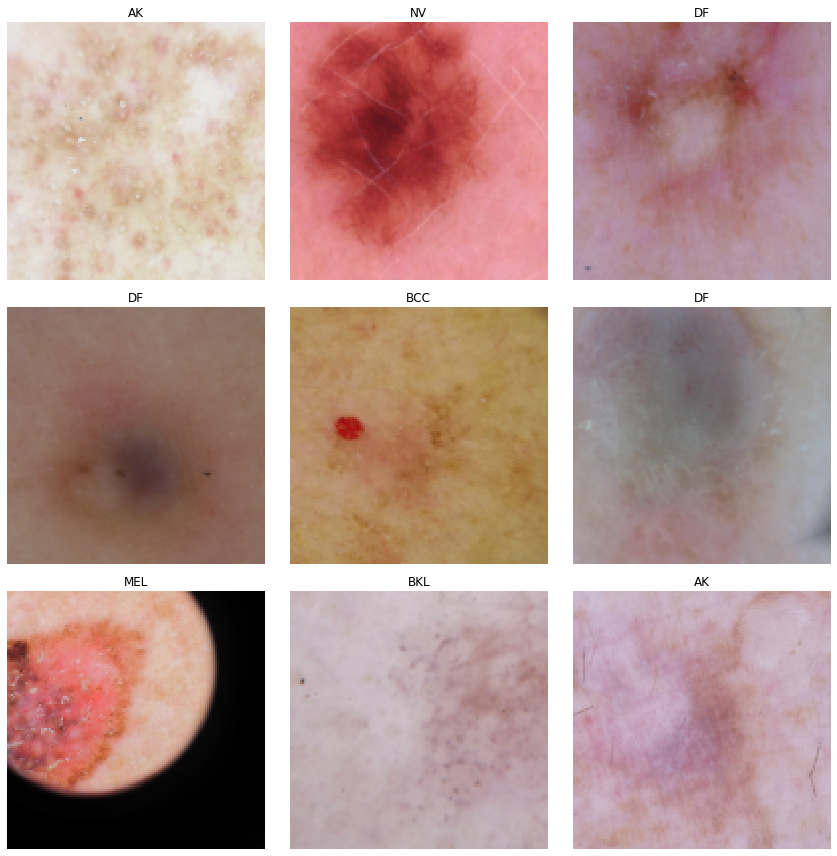

In [202]:
data.show_batch(3)

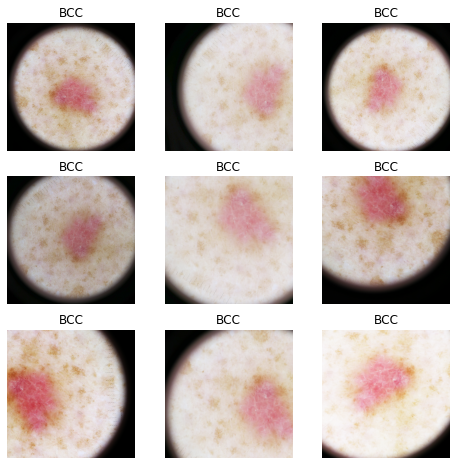

In [203]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [204]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 BCC     381
MEL     374
NV      366
BKL     363
AK      362
VASC    203
DF      201
dtype: int64 

 valid_count: 
 AK      102
BKL     101
NV       98
MEL      90
BCC      83
VASC     50
DF       38
dtype: int64
ratios:
AK      0.281768
BCC     0.217848
BKL     0.278237
DF      0.189055
MEL     0.240642
NV      0.267760
VASC    0.246305
dtype: float64 %


In [245]:
#export

# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

def get_class_weights(data):
    train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
    train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

    weighted_classes = [{c: (sum(train_count) / train_count[c] * len(data.classes))} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ]
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    class_weights = class_weights / sum(class_weights)
    return class_weights

def train_learner(learner, name, epochs=8, lr=1e-3, wd = 1e-6, balanced=True,seed=1):
    if balanced: learner.loss_func = CrossEntropyFlat(weight = get_class_weights(learner.data))
    random_seed(seed,True)
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(epochs,max_lr=lr,wd=wd
                          ,callbacks = [
                            SaveModelCallback(learn=learner,name=log_name,monitor='accuracy'),
                            CSVLogger(learn=learner,filename=log_name),
                            ]
                         )

# Training

First let's see the baseline result
* Images prerezised to: 128px

* get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.6, max_lighting=.3,p_affine=1, max_warp=0)
* batch_size = 16
* random_seed 1
* epochs = 30 
* one_cycle_policy, max_lr =7.59E-04, wd 1e-6
* balancing per class: True
* pretrained = True
* unfreezed = True
* EfficientNet-b0

train_count: 
 BCC     381
MEL     374
NV      366
BKL     363
AK      362
VASC    203
DF      201
dtype: int64 

 valid_count: 
 AK      102
BKL     101
NV       98
MEL      90
BCC      83
VASC     50
DF       38
dtype: int64
ratios:
AK      0.281768
BCC     0.217848
BKL     0.278237
DF      0.189055
MEL     0.240642
NV      0.267760
VASC    0.246305
dtype: float64 %

### Baseline

In [246]:
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.model import MBConvBlock
from efficientnet_pytorch.utils import drop_connect

from torchvision.models.resnet import Bottleneck
import types

In [247]:
images_folder = 'picked_30_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

In [248]:
random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0,metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph])

Loaded pretrained weights for efficientnet-b0


[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.873300,1.816851,0.706406,0.293594,0.504339,00:13
1,1.611805,1.415274,0.501779,0.498221,0.508741,00:13
2,1.316208,1.153904,0.434164,0.565836,0.404960,00:13
3,1.131122,1.126505,0.432384,0.567616,0.567925,00:13
4,1.061959,1.063067,0.405694,0.594306,0.532812,00:13
5,1.025109,1.895772,0.564057,0.435943,0.411148,00:14
6,1.008187,1.196067,0.443060,0.556939,0.507156,00:13
7,0.991986,1.240917,0.428826,0.571174,0.474181,00:13
8,1.068571,1.081229,0.402135,0.597865,0.264507,00:13
9,0.975688,1.087504,0.384342,0.615658,0.524813,00:13


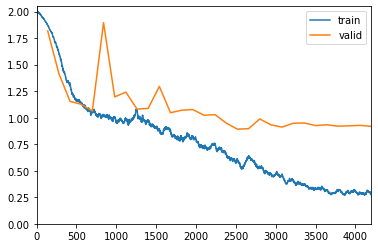

Better model found at epoch 0 with accuracy value: 0.2935943007469177.
Better model found at epoch 1 with accuracy value: 0.49822065234184265.
Better model found at epoch 2 with accuracy value: 0.5658363103866577.
Better model found at epoch 3 with accuracy value: 0.5676156878471375.
Better model found at epoch 4 with accuracy value: 0.5943060517311096.
Better model found at epoch 8 with accuracy value: 0.5978647470474243.
Better model found at epoch 9 with accuracy value: 0.6156583428382874.
Better model found at epoch 13 with accuracy value: 0.628113865852356.
Better model found at epoch 14 with accuracy value: 0.6352313160896301.
Better model found at epoch 16 with accuracy value: 0.6672598123550415.
Better model found at epoch 18 with accuracy value: 0.6743772029876709.
Better model found at epoch 20 with accuracy value: 0.6975088715553284.
Better model found at epoch 26 with accuracy value: 0.708185076713562.
Better model found at epoch 27 with accuracy value: 0.7188612222671509.


In [249]:
train_learner(learn_b0,'EfficientNet-b0',lr=7.59E-04,epochs=30)

### ARL

In [250]:
images_folder = 'picked_30_ISIC_2019_Training_Input'
data = reload_dataset(images_folder)

In [11]:
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.model import MBConvBlock,MemoryEfficientSwish
from efficientnet_pytorch.utils import drop_connect

from torchvision.models.resnet import Bottleneck
import types

In [12]:
%psource MBConvBlock

In [252]:
random_seed(1,True)

model_name = 'efficientnet-b0'
model_b0_arl = EfficientNet.from_pretrained(model_name)
model_b0_arl._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

Loaded pretrained weights for efficientnet-b0


In [1]:
alpha_initial_value = 0.001
    
def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs 
            x += (inputs 
                     * self.softmaxLayer(x.view(*x.size()[:2], -1)).view_as(x) 
                     * self.alpha) # skip connection
        return x
    
def add_attn_to_forward_func(a_module):
    a_module.forward = types.MethodType( forward,a_module)
    
def add_attn_params(a_module):
    a_module.softmaxLayer = nn.Softmax(2);
    a_module.alpha = nn.Parameter(torch.tensor(alpha_initial_value))
#     print(f'Added attention to {a_module}')
    
    
def change_basic_blocks(a_module):
    if not isinstance(a_module, MBConvBlock): return
    add_attn_params(a_module)
    add_attn_to_forward_func(a_module)

In [2]:
apply_leaf(model_b0_arl, change_basic_blocks)

NameError: name 'apply_leaf' is not defined

In [255]:
mbconvs = [bn for bn in model_b0_arl.modules() if isinstance(bn,MBConvBlock)]

In [256]:
class Alphas(ActivationStats):
    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return m.alpha.item(),m.alpha.item()

In [ ]:
learn_b0_arl = Learner(data,model_b0_arl,metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph, partial(Alphas, modules=mbconvs)])
# learn_b0_arl.summary()

[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_EfficientNet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.873293,1.816844,0.706406,0.293594,0.504289,00:14
1,1.611793,1.415274,0.501779,0.498221,0.508665,00:14
2,1.316206,1.153921,0.434164,0.565836,0.404985,00:13
3,1.131106,1.126182,0.432384,0.567616,0.568277,00:14
4,1.062531,1.066886,0.407473,0.592527,0.533566,00:14
5,1.014526,1.870162,0.555160,0.444840,0.431018,00:13
6,0.999542,1.168835,0.416370,0.583630,0.506879,00:13
7,1.019812,1.176858,0.460854,0.539146,0.487914,00:13
8,1.076814,1.071439,0.419929,0.580071,0.377896,00:13
9,0.935570,1.220651,0.387900,0.612100,0.544986,00:13


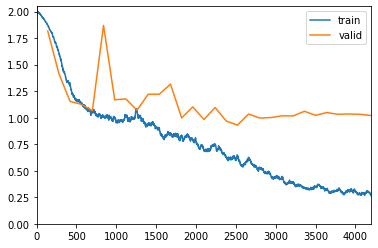

Better model found at epoch 0 with accuracy value: 0.2935943007469177.
Better model found at epoch 1 with accuracy value: 0.49822065234184265.
Better model found at epoch 2 with accuracy value: 0.5658363103866577.
Better model found at epoch 3 with accuracy value: 0.5676156878471375.
Better model found at epoch 4 with accuracy value: 0.5925266742706299.
Better model found at epoch 9 with accuracy value: 0.6120996475219727.
Better model found at epoch 12 with accuracy value: 0.6209964156150818.
Better model found at epoch 14 with accuracy value: 0.6423487663269043.
Better model found at epoch 16 with accuracy value: 0.6814946532249451.
Better model found at epoch 17 with accuracy value: 0.6957295536994934.
Better model found at epoch 21 with accuracy value: 0.7028470039367676.
Better model found at epoch 22 with accuracy value: 0.708185076713562.


In [258]:
train_learner(learn_b0_arl,'EfficientNet-b0',lr=7.59E-04,epochs=30)

# Compare

Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_efficientnet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.879535,1.831609,0.724199,0.275801,0.501019,00:13
1,1.672462,1.513370,0.521352,0.478648,0.484393,00:13
2,1.399897,1.228704,0.457295,0.542705,0.449908,00:13
3,1.179119,1.109408,0.411032,0.588968,0.483387,00:13
4,1.070611,1.046815,0.403915,0.596085,0.552205,00:13
5,1.004560,1.308364,0.469751,0.530249,0.413738,00:13
6,0.975472,1.090915,0.386121,0.613879,0.537364,00:13
7,0.967494,1.169228,0.432384,0.567616,0.527379,00:13
8,1.052126,1.076172,0.409253,0.590747,0.351359,00:13
9,0.948002,1.089274,0.382562,0.617438,0.510074,00:13


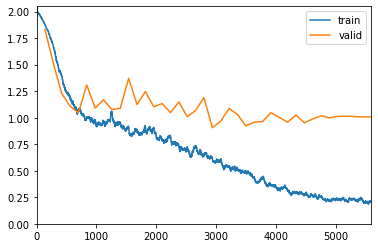

Better model found at epoch 0 with accuracy value: 0.2758007049560547.
Better model found at epoch 1 with accuracy value: 0.4786476790904999.
Better model found at epoch 2 with accuracy value: 0.5427046418190002.
Better model found at epoch 3 with accuracy value: 0.5889679789543152.
Better model found at epoch 4 with accuracy value: 0.5960854291915894.
Better model found at epoch 6 with accuracy value: 0.6138790249824524.
Better model found at epoch 9 with accuracy value: 0.6174377202987671.
Better model found at epoch 17 with accuracy value: 0.6512455344200134.
Better model found at epoch 20 with accuracy value: 0.6779359579086304.
Better model found at epoch 21 with accuracy value: 0.6797152757644653.
Better model found at epoch 24 with accuracy value: 0.6868327260017395.
Better model found at epoch 27 with accuracy value: 0.6921707987785339.
Better model found at epoch 28 with accuracy value: 0.7135231494903564.
Better model found at epoch 35 with accuracy value: 0.7153024673461914.

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.879529,1.831603,0.724199,0.275801,0.500993,00:14
1,1.672450,1.513368,0.521352,0.478648,0.484468,00:14
2,1.399892,1.228715,0.457295,0.542705,0.449958,00:14
3,1.179112,1.109341,0.411032,0.588968,0.483336,00:14
4,1.070593,1.046523,0.405694,0.594306,0.552179,00:14
5,1.004586,1.308348,0.469751,0.530249,0.413462,00:14
6,0.975360,1.090019,0.391459,0.608541,0.535906,00:14
7,0.966852,1.199231,0.441281,0.558719,0.512136,00:14
8,1.056921,1.053020,0.384342,0.615658,0.329753,00:13
9,0.934168,1.064172,0.391459,0.608541,0.438363,00:14


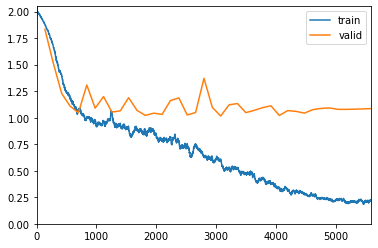

Better model found at epoch 0 with accuracy value: 0.2758007049560547.
Better model found at epoch 1 with accuracy value: 0.4786476790904999.
Better model found at epoch 2 with accuracy value: 0.5427046418190002.
Better model found at epoch 3 with accuracy value: 0.5889679789543152.
Better model found at epoch 4 with accuracy value: 0.5943060517311096.
Better model found at epoch 6 with accuracy value: 0.608540952205658.
Better model found at epoch 8 with accuracy value: 0.6156583428382874.
Better model found at epoch 13 with accuracy value: 0.6583629846572876.
Better model found at epoch 22 with accuracy value: 0.6690391302108765.
Better model found at epoch 25 with accuracy value: 0.6832740306854248.
Better model found at epoch 28 with accuracy value: 0.6850534081459045.
Better model found at epoch 29 with accuracy value: 0.7028470039367676.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.896048,1.836715,0.736655,0.263345,0.484795,00:13
1,1.665133,1.513494,0.524911,0.475089,0.497900,00:13
2,1.365451,1.252372,0.485765,0.514235,0.474382,00:13
3,1.182415,1.092993,0.427046,0.572954,0.357623,00:13
4,1.094885,1.010197,0.396797,0.603203,0.470785,00:13
5,1.045388,1.018556,0.400356,0.599644,0.400005,00:13
6,0.993315,1.032883,0.409253,0.590747,0.453706,00:13
7,0.969251,1.079352,0.418149,0.581851,0.445532,00:13
8,0.951870,1.473454,0.487544,0.512456,0.359207,00:13
9,0.963602,1.180233,0.435943,0.564057,0.446311,00:13


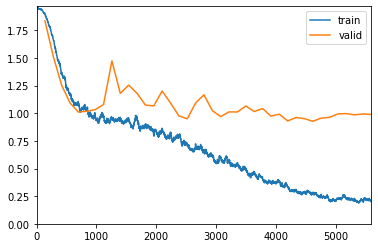

Better model found at epoch 0 with accuracy value: 0.2633451819419861.
Better model found at epoch 1 with accuracy value: 0.4750889539718628.
Better model found at epoch 2 with accuracy value: 0.5142349004745483.
Better model found at epoch 3 with accuracy value: 0.5729537606239319.
Better model found at epoch 4 with accuracy value: 0.6032028198242188.
Better model found at epoch 13 with accuracy value: 0.6298932433128357.
Better model found at epoch 17 with accuracy value: 0.6512455344200134.
Better model found at epoch 19 with accuracy value: 0.6565836071968079.
Better model found at epoch 21 with accuracy value: 0.6868327260017395.
Better model found at epoch 24 with accuracy value: 0.6886121034622192.
Better model found at epoch 25 with accuracy value: 0.6975088715553284.
Better model found at epoch 27 with accuracy value: 0.7010676264762878.
Better model found at epoch 29 with accuracy value: 0.7046263217926025.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.508287292817

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.896043,1.836705,0.736655,0.263345,0.484820,00:13
1,1.665120,1.513471,0.524911,0.475089,0.497925,00:13
2,1.365435,1.252433,0.485765,0.514235,0.474482,00:14
3,1.182399,1.093001,0.427046,0.572954,0.358025,00:14
4,1.094824,1.010107,0.395018,0.604982,0.470433,00:14
5,1.045370,1.018987,0.400356,0.599644,0.400081,00:14
6,0.993347,1.034402,0.409253,0.590747,0.454813,00:13
7,0.970684,1.081483,0.407473,0.592527,0.459064,00:13
8,0.947057,1.535702,0.491103,0.508897,0.369268,00:13
9,0.973267,1.131664,0.434164,0.565836,0.476620,00:13


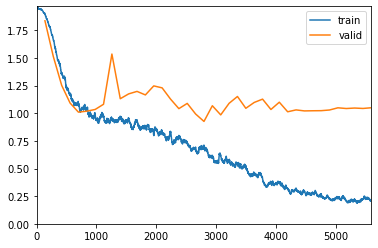

Better model found at epoch 0 with accuracy value: 0.2633451819419861.
Better model found at epoch 1 with accuracy value: 0.4750889539718628.
Better model found at epoch 2 with accuracy value: 0.5142349004745483.
Better model found at epoch 3 with accuracy value: 0.5729537606239319.
Better model found at epoch 4 with accuracy value: 0.6049821972846985.
Better model found at epoch 10 with accuracy value: 0.6103202700614929.
Better model found at epoch 16 with accuracy value: 0.6156583428382874.
Better model found at epoch 18 with accuracy value: 0.6352313160896301.
Better model found at epoch 19 with accuracy value: 0.6619216799736023.
Better model found at epoch 21 with accuracy value: 0.6708185076713562.
Better model found at epoch 22 with accuracy value: 0.6779359579086304.
Better model found at epoch 29 with accuracy value: 0.7170818448066711.
Better model found at epoch 36 with accuracy value: 0.725978672504425.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.5082872928176

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.890566,1.827395,0.693950,0.306050,0.495586,00:13
1,1.662506,1.507908,0.537367,0.462633,0.483688,00:13
2,1.403119,1.229096,0.450178,0.549822,0.439998,00:13
3,1.181357,1.093246,0.407473,0.592527,0.423397,00:13
4,1.076826,1.057729,0.446619,0.553381,0.391076,00:13
5,1.037329,1.039285,0.396797,0.603203,0.428277,00:13
6,0.999095,1.015615,0.432384,0.567616,0.499107,00:13
7,0.992152,1.188901,0.437722,0.562278,0.313505,00:13
8,0.932716,1.687080,0.521352,0.478648,0.402621,00:13
9,0.983441,1.184083,0.409253,0.590747,0.355384,00:13


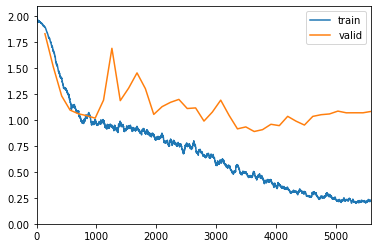

Better model found at epoch 0 with accuracy value: 0.30604982376098633.
Better model found at epoch 1 with accuracy value: 0.4626334607601166.
Better model found at epoch 2 with accuracy value: 0.5498220920562744.
Better model found at epoch 3 with accuracy value: 0.5925266742706299.
Better model found at epoch 5 with accuracy value: 0.6032028198242188.
Better model found at epoch 13 with accuracy value: 0.6138790249824524.
Better model found at epoch 14 with accuracy value: 0.626334547996521.
Better model found at epoch 17 with accuracy value: 0.628113865852356.
Better model found at epoch 18 with accuracy value: 0.6565836071968079.
Better model found at epoch 23 with accuracy value: 0.6690391302108765.
Better model found at epoch 24 with accuracy value: 0.6814946532249451.
Better model found at epoch 25 with accuracy value: 0.6921707987785339.
Better model found at epoch 27 with accuracy value: 0.6975088715553284.
Better model found at epoch 28 with accuracy value: 0.708185076713562.

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.890560,1.827400,0.693950,0.306050,0.495611,00:14
1,1.662476,1.507897,0.537367,0.462633,0.483739,00:14
2,1.403082,1.229122,0.450178,0.549822,0.439897,00:14
3,1.181371,1.093273,0.407473,0.592527,0.423573,00:14
4,1.076718,1.057477,0.444840,0.555160,0.391101,00:14
5,1.037423,1.039020,0.398576,0.601424,0.428579,00:13
6,0.999839,1.017282,0.428826,0.571174,0.496667,00:14
7,0.985514,1.251687,0.457295,0.542705,0.313605,00:14
8,0.920144,1.350583,0.478648,0.521352,0.494127,00:14
9,0.986343,1.156048,0.409253,0.590747,0.395528,00:14


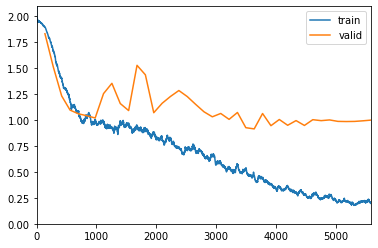

Better model found at epoch 0 with accuracy value: 0.30604982376098633.
Better model found at epoch 1 with accuracy value: 0.4626334607601166.
Better model found at epoch 2 with accuracy value: 0.5498220920562744.
Better model found at epoch 3 with accuracy value: 0.5925266742706299.
Better model found at epoch 5 with accuracy value: 0.6014235019683838.
Better model found at epoch 10 with accuracy value: 0.6103202700614929.
Better model found at epoch 14 with accuracy value: 0.6192170977592468.
Better model found at epoch 18 with accuracy value: 0.6352313160896301.
Better model found at epoch 20 with accuracy value: 0.6405693888664246.
Better model found at epoch 21 with accuracy value: 0.6690391302108765.
Better model found at epoch 26 with accuracy value: 0.6814946532249451.
Better model found at epoch 27 with accuracy value: 0.709964394569397.
Better model found at epoch 32 with accuracy value: 0.7135231494903564.
Better model found at epoch 34 with accuracy value: 0.722419917583465

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.885219,1.831606,0.713523,0.286477,0.490228,00:13
1,1.649215,1.509870,0.519573,0.480427,0.501346,00:13
2,1.350119,1.217607,0.453737,0.546263,0.487637,00:13
3,1.189317,1.127699,0.414591,0.585409,0.461353,00:13
4,1.027788,1.035918,0.380783,0.619217,0.468999,00:13
5,1.025440,1.083601,0.419929,0.580071,0.611364,00:13
6,0.935980,1.064013,0.412811,0.587189,0.563498,00:13
7,0.979905,1.190837,0.451957,0.548043,0.484217,00:13
8,0.929362,1.190271,0.416370,0.583630,0.454662,00:13
9,0.967054,1.123294,0.386121,0.613879,0.278769,00:13


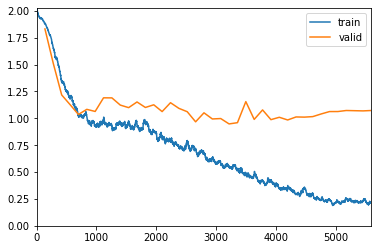

Better model found at epoch 0 with accuracy value: 0.28647688031196594.
Better model found at epoch 1 with accuracy value: 0.4804270565509796.
Better model found at epoch 2 with accuracy value: 0.5462633371353149.
Better model found at epoch 3 with accuracy value: 0.5854092240333557.
Better model found at epoch 4 with accuracy value: 0.6192170977592468.
Better model found at epoch 11 with accuracy value: 0.6316726207733154.
Better model found at epoch 18 with accuracy value: 0.6423487663269043.
Better model found at epoch 20 with accuracy value: 0.6619216799736023.
Better model found at epoch 21 with accuracy value: 0.6725978851318359.
Better model found at epoch 22 with accuracy value: 0.6850534081459045.
Better model found at epoch 25 with accuracy value: 0.7046263217926025.
Better model found at epoch 37 with accuracy value: 0.709964394569397.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.885214,1.831599,0.713523,0.286477,0.490228,00:13
1,1.649192,1.509832,0.519573,0.480427,0.501421,00:14
2,1.350104,1.217636,0.453737,0.546263,0.487637,00:14
3,1.189311,1.127707,0.414591,0.585409,0.460950,00:14
4,1.027710,1.035844,0.380783,0.619217,0.468672,00:14
5,1.025200,1.083821,0.414591,0.585409,0.611012,00:14
6,0.935492,1.065330,0.409253,0.590747,0.563775,00:14
7,0.975037,1.189874,0.446619,0.553381,0.472068,00:14
8,0.942241,1.104566,0.407473,0.592527,0.455693,00:14
9,0.970299,1.175994,0.428826,0.571174,0.386649,00:14


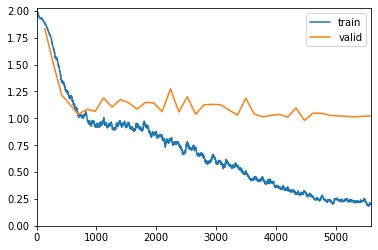

Better model found at epoch 0 with accuracy value: 0.28647688031196594.
Better model found at epoch 1 with accuracy value: 0.4804270565509796.
Better model found at epoch 2 with accuracy value: 0.5462633371353149.
Better model found at epoch 3 with accuracy value: 0.5854092240333557.
Better model found at epoch 4 with accuracy value: 0.6192170977592468.
Better model found at epoch 14 with accuracy value: 0.628113865852356.
Better model found at epoch 15 with accuracy value: 0.6298932433128357.
Better model found at epoch 18 with accuracy value: 0.6476868391036987.
Better model found at epoch 22 with accuracy value: 0.6530249118804932.
Better model found at epoch 23 with accuracy value: 0.6761565804481506.
Better model found at epoch 26 with accuracy value: 0.6832740306854248.
Better model found at epoch 28 with accuracy value: 0.6975088715553284.
Better model found at epoch 29 with accuracy value: 0.7010676264762878.
Better model found at epoch 33 with accuracy value: 0.708185076713562

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.876917,1.830875,0.725979,0.274021,0.496944,00:13
1,1.690338,1.531023,0.521352,0.478648,0.491662,00:13
2,1.405619,1.265011,0.473310,0.526690,0.488971,00:13
3,1.154293,1.088719,0.398576,0.601424,0.536384,00:13
4,1.095302,1.070610,0.409253,0.590747,0.367533,00:13
5,1.037627,1.086104,0.434164,0.565836,0.435772,00:13
6,0.984137,1.013214,0.398576,0.601424,0.378550,00:14
7,0.941208,1.210553,0.437722,0.562278,0.337299,00:13
8,0.962088,1.023285,0.402135,0.597865,0.519078,00:13
9,0.972000,1.246645,0.402135,0.597865,0.541942,00:13


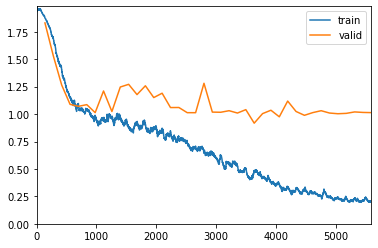

Better model found at epoch 0 with accuracy value: 0.27402135729789734.
Better model found at epoch 1 with accuracy value: 0.4786476790904999.
Better model found at epoch 2 with accuracy value: 0.5266903638839722.
Better model found at epoch 3 with accuracy value: 0.6014235019683838.
Better model found at epoch 10 with accuracy value: 0.6067615747451782.
Better model found at epoch 13 with accuracy value: 0.6156583428382874.
Better model found at epoch 14 with accuracy value: 0.6209964156150818.
Better model found at epoch 17 with accuracy value: 0.6530249118804932.
Better model found at epoch 22 with accuracy value: 0.6548042893409729.
Better model found at epoch 23 with accuracy value: 0.6690391302108765.
Better model found at epoch 24 with accuracy value: 0.6797152757644653.
Better model found at epoch 25 with accuracy value: 0.6975088715553284.
Better model found at epoch 28 with accuracy value: 0.7028470039367676.
Better model found at epoch 30 with accuracy value: 0.7099643945693

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.876916,1.830871,0.725979,0.274021,0.496994,00:14
1,1.690328,1.531004,0.521352,0.478648,0.491637,00:14
2,1.405601,1.265001,0.473310,0.526690,0.489046,00:14
3,1.154298,1.088735,0.398576,0.601424,0.536333,00:14
4,1.095282,1.070337,0.407473,0.592527,0.367809,00:14
5,1.037674,1.085541,0.432384,0.567616,0.435345,00:14
6,0.981318,1.016826,0.407473,0.592527,0.370727,00:14
7,0.953922,1.189879,0.435943,0.564057,0.366225,00:14
8,0.972671,1.031201,0.386121,0.613879,0.489926,00:14
9,0.982102,1.149010,0.398576,0.601424,0.526750,00:15


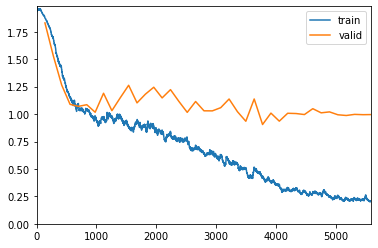

Better model found at epoch 0 with accuracy value: 0.27402135729789734.
Better model found at epoch 1 with accuracy value: 0.4786476790904999.
Better model found at epoch 2 with accuracy value: 0.5266903638839722.
Better model found at epoch 3 with accuracy value: 0.6014235019683838.
Better model found at epoch 8 with accuracy value: 0.6138790249824524.
Better model found at epoch 13 with accuracy value: 0.6245551705360413.
Better model found at epoch 17 with accuracy value: 0.6387900114059448.
Better model found at epoch 20 with accuracy value: 0.6512455344200134.
Better model found at epoch 22 with accuracy value: 0.6565836071968079.
Better model found at epoch 23 with accuracy value: 0.6619216799736023.
Better model found at epoch 24 with accuracy value: 0.6850534081459045.
Better model found at epoch 27 with accuracy value: 0.6992882490158081.
Better model found at epoch 28 with accuracy value: 0.708185076713562.
Better model found at epoch 32 with accuracy value: 0.718861222267150

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.870602,1.833543,0.725979,0.274021,0.509219,00:13
1,1.683582,1.516778,0.526690,0.473310,0.476067,00:13
2,1.389824,1.212887,0.451957,0.548043,0.505647,00:13
3,1.207311,1.063850,0.403915,0.596085,0.472194,00:13
4,1.082421,1.055173,0.409253,0.590747,0.511457,00:13
5,1.075379,0.951868,0.346975,0.653025,0.406243,00:13
6,1.035257,0.990533,0.389680,0.610320,0.447971,00:13
7,0.996759,1.071787,0.427046,0.572954,0.574666,00:13
8,0.984659,1.028936,0.382562,0.617438,0.518978,00:13
9,0.968765,1.037263,0.398576,0.601424,0.493548,00:13


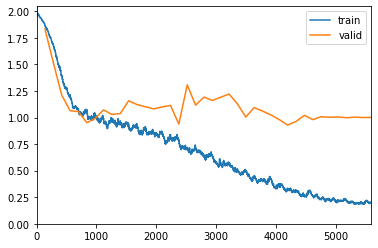

Better model found at epoch 0 with accuracy value: 0.27402135729789734.
Better model found at epoch 1 with accuracy value: 0.47330960631370544.
Better model found at epoch 2 with accuracy value: 0.5480427145957947.
Better model found at epoch 3 with accuracy value: 0.5960854291915894.
Better model found at epoch 5 with accuracy value: 0.6530249118804932.
Better model found at epoch 16 with accuracy value: 0.6565836071968079.
Better model found at epoch 23 with accuracy value: 0.6601423621177673.
Better model found at epoch 24 with accuracy value: 0.663701057434082.
Better model found at epoch 27 with accuracy value: 0.6832740306854248.
Better model found at epoch 28 with accuracy value: 0.6868327260017395.
Better model found at epoch 29 with accuracy value: 0.690391480922699.
Better model found at epoch 30 with accuracy value: 0.7064056992530823.
Better model found at epoch 32 with accuracy value: 0.7117437720298767.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.508287292817

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.870595,1.833532,0.725979,0.274021,0.509344,00:14
1,1.683561,1.516784,0.526690,0.473310,0.476218,00:14
2,1.389805,1.212866,0.451957,0.548043,0.505697,00:14
3,1.207266,1.063832,0.403915,0.596085,0.472093,00:14
4,1.082361,1.055054,0.411032,0.588968,0.511910,00:14
5,1.075276,0.952557,0.345196,0.654804,0.406419,00:14
6,1.034941,0.991462,0.387900,0.612100,0.449405,00:14
7,0.996205,1.076232,0.430605,0.569395,0.581432,00:14
8,0.988723,1.060261,0.395018,0.604982,0.527303,00:14
9,0.964105,1.094481,0.414591,0.585409,0.408381,00:14


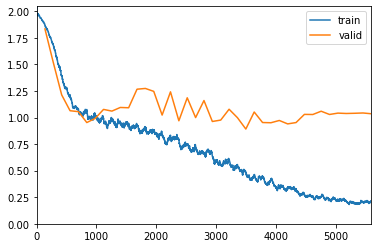

Better model found at epoch 0 with accuracy value: 0.27402135729789734.
Better model found at epoch 1 with accuracy value: 0.47330960631370544.
Better model found at epoch 2 with accuracy value: 0.5480427145957947.
Better model found at epoch 3 with accuracy value: 0.5960854291915894.
Better model found at epoch 5 with accuracy value: 0.6548042893409729.
Better model found at epoch 24 with accuracy value: 0.6850534081459045.
Better model found at epoch 28 with accuracy value: 0.6992882490158081.
Better model found at epoch 32 with accuracy value: 0.7028470039367676.
Better model found at epoch 35 with accuracy value: 0.708185076713562.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, {'VASC': 77.58620689655173}]
Saving log on:  2019_imgsz_128_efficientnet-b0


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.887986,1.831793,0.724199,0.275801,0.485600,00:13
1,1.665897,1.507436,0.501779,0.498221,0.509294,00:13
2,1.392234,1.222608,0.451957,0.548043,0.469226,00:13
3,1.184103,1.083334,0.391459,0.608541,0.485374,00:13
4,1.074980,1.022445,0.403915,0.596085,0.533063,00:13
5,1.074921,1.057806,0.419929,0.580071,0.405312,00:13
6,0.993008,1.073768,0.421708,0.578292,0.478381,00:13
7,0.942361,1.148646,0.427046,0.572954,0.353975,00:13
8,0.966859,1.188694,0.428826,0.571174,0.502176,00:13
9,0.995338,1.157368,0.423488,0.576512,0.407023,00:13


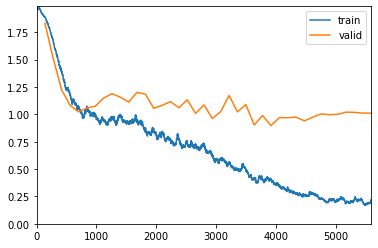

Better model found at epoch 0 with accuracy value: 0.2758007049560547.
Better model found at epoch 1 with accuracy value: 0.49822065234184265.
Better model found at epoch 2 with accuracy value: 0.5480427145957947.
Better model found at epoch 3 with accuracy value: 0.608540952205658.
Better model found at epoch 11 with accuracy value: 0.6138790249824524.
Better model found at epoch 13 with accuracy value: 0.6245551705360413.
Better model found at epoch 16 with accuracy value: 0.6370106935501099.
Better model found at epoch 20 with accuracy value: 0.6779359579086304.
Better model found at epoch 25 with accuracy value: 0.7028470039367676.
Better model found at epoch 27 with accuracy value: 0.709964394569397.
Better model found at epoch 31 with accuracy value: 0.7188612222671509.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.35820895522389}, {'MEL': 42.11229946524064}, {'NV': 43.0327868852459}, 

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.887982,1.831788,0.724199,0.275801,0.485600,00:14
1,1.665882,1.507426,0.503559,0.496441,0.509244,00:14
2,1.392219,1.222630,0.451957,0.548043,0.469376,00:14
3,1.184076,1.083299,0.391459,0.608541,0.485499,00:13
4,1.075010,1.022574,0.403915,0.596085,0.533566,00:14
5,1.074218,1.055857,0.418149,0.581851,0.409312,00:14
6,0.989837,1.080577,0.411032,0.588968,0.473325,00:14
7,0.937955,1.161456,0.444840,0.555160,0.358151,00:14
8,0.940975,1.105655,0.419929,0.580071,0.562542,00:14
9,0.958666,1.155242,0.441281,0.558719,0.390548,00:13


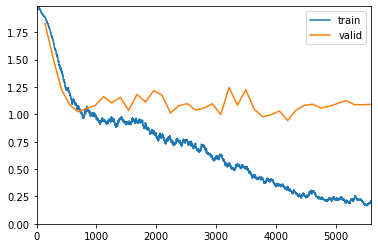

Better model found at epoch 0 with accuracy value: 0.2758007049560547.
Better model found at epoch 1 with accuracy value: 0.4964412748813629.
Better model found at epoch 2 with accuracy value: 0.5480427145957947.
Better model found at epoch 3 with accuracy value: 0.608540952205658.
Better model found at epoch 14 with accuracy value: 0.628113865852356.
Better model found at epoch 16 with accuracy value: 0.6334519386291504.
Better model found at epoch 18 with accuracy value: 0.6565836071968079.
Better model found at epoch 21 with accuracy value: 0.6832740306854248.
Better model found at epoch 25 with accuracy value: 0.6886121034622192.
Better model found at epoch 28 with accuracy value: 0.6992882490158081.
Better model found at epoch 29 with accuracy value: 0.7028470039367676.
Better model found at epoch 34 with accuracy value: 0.7046263217926025.
Loaded pretrained weights for efficientnet-b0
[{'AK': 43.50828729281768}, {'BCC': 41.338582677165356}, {'BKL': 43.388429752066116}, {'DF': 78.

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.885186,1.829137,0.718861,0.281139,0.483965,00:13
1,1.659169,1.533834,0.530249,0.469751,0.493423,00:13
2,1.399181,1.249961,0.466192,0.533808,0.513218,00:13
3,1.209597,1.165613,0.421708,0.578292,0.407677,00:13
4,1.075639,1.044836,0.407473,0.592527,0.563901,00:13
5,1.036858,1.078040,0.416370,0.583630,0.549287,00:13
6,0.979026,1.084444,0.409253,0.590747,0.380486,00:13
7,0.996853,1.100394,0.428826,0.571174,0.390673,00:13
8,0.975095,1.051454,0.382562,0.617438,0.446110,00:13
9,0.983054,1.037552,0.379004,0.620996,0.477149,00:13


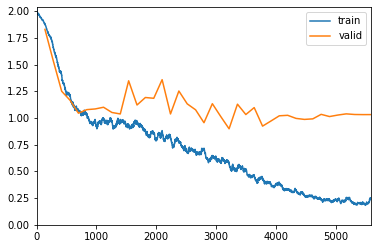

Better model found at epoch 0 with accuracy value: 0.2811387777328491.
Better model found at epoch 1 with accuracy value: 0.46975088119506836.
Better model found at epoch 2 with accuracy value: 0.5338078141212463.
Better model found at epoch 3 with accuracy value: 0.5782918334007263.
Better model found at epoch 4 with accuracy value: 0.5925266742706299.
Better model found at epoch 8 with accuracy value: 0.6174377202987671.
Better model found at epoch 9 with accuracy value: 0.6209964156150818.
Better model found at epoch 17 with accuracy value: 0.626334547996521.
Better model found at epoch 18 with accuracy value: 0.6334519386291504.
Better model found at epoch 19 with accuracy value: 0.645907461643219.
Better model found at epoch 21 with accuracy value: 0.6583629846572876.
Better model found at epoch 22 with accuracy value: 0.6797152757644653.
Better model found at epoch 26 with accuracy value: 0.690391480922699.
Better model found at epoch 29 with accuracy value: 0.6957295536994934.
B

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.885183,1.829131,0.718861,0.281139,0.484091,00:14
1,1.659158,1.533821,0.530249,0.469751,0.493423,00:19
2,1.399165,1.249984,0.466192,0.533808,0.513218,00:20
3,1.209624,1.165284,0.421708,0.578292,0.407878,00:23
4,1.076044,1.046990,0.411032,0.588968,0.564957,00:20
5,1.036774,1.078089,0.419929,0.580071,0.546193,00:23
6,0.975174,1.079602,0.402135,0.597865,0.380688,00:21
7,0.991109,1.115438,0.414591,0.585409,0.405664,00:21
8,0.986224,1.150700,0.411032,0.588968,0.446060,00:21
9,1.002071,1.098567,0.389680,0.610320,0.534396,00:20


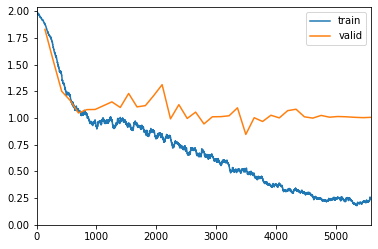

Better model found at epoch 0 with accuracy value: 0.2811387777328491.
Better model found at epoch 1 with accuracy value: 0.46975088119506836.
Better model found at epoch 2 with accuracy value: 0.5338078141212463.
Better model found at epoch 3 with accuracy value: 0.5782918334007263.
Better model found at epoch 4 with accuracy value: 0.5889679789543152.
Better model found at epoch 6 with accuracy value: 0.5978647470474243.
Better model found at epoch 9 with accuracy value: 0.6103202700614929.
Better model found at epoch 11 with accuracy value: 0.6192170977592468.
Better model found at epoch 15 with accuracy value: 0.6494662165641785.
Better model found at epoch 19 with accuracy value: 0.6725978851318359.
Better model found at epoch 24 with accuracy value: 0.7046263217926025.
Better model found at epoch 33 with accuracy value: 0.7117437720298767.


In [260]:
from efficientnet_pytorch import EfficientNet
seeds = [1,2,3,4,5,6,7,8]
epochs = 40
images_folder = 'picked_30_ISIC_2019_Training_Input'

for s in seeds:
    
    data = reload_dataset(images_folder)

    random_seed(1,True)

    model_name = 'efficientnet-b0'
    model_b0 = EfficientNet.from_pretrained(model_name)
    model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

    learn_b0 = Learner(data,model_b0,metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph])

    train_learner(learn_b0,'efficientnet-b0',epochs=epochs, seed=s,lr=7.59E-04)
    l1 = list(map(lambda x: x[1], learn_b0.recorder.metrics))
    
    
    
    
    #Con attention
    data = reload_dataset(destFolder)

    random_seed(1,True)

    model_name = 'efficientnet-b0'
    model_b0_arl = EfficientNet.from_pretrained(model_name)
    model_b0_arl._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536
    apply_leaf(model_b0_arl, change_basic_blocks)

    mbconvs = [bn for bn in model_b0_arl.modules() if isinstance(bn,MBConvBlock)]

    class Alphas(ActivationStats):
        def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
            "Take the mean and std of `o`."
            return m.alpha.item(),m.alpha.item()

    learn_b0_arl = Learner(data,model_b0_arl,metrics=[error_rate,accuracy,AUROC()],
                        callback_fns=[ShowGraph, partial(Alphas, modules=mbconvs)])
    

    # learn_b0.summary()
    train_learner(learn_b0_arl,'learn_b0_arl',epochs=epochs, seed=s,lr=7.59E-04)
    
    l2 = list(map(lambda x: x[1], learn_b0_arl.recorder.metrics))
    
    f = open(f'EfficientNet_attn_run_seed_{s}.txt','w+')
    f.write('Baseline, EfficientNet With ARL\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()

# TODO

Plot activations for alpha

In [267]:
learn_b0_arl.alphas.stats.shape

torch.Size([2, 16, 5600])

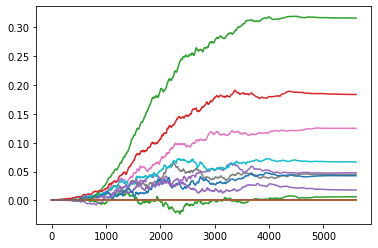

In [269]:
ps = list(learn_b0_arl.model.named_parameters())

ls = [n for n in ps if 'alpha' in n[0]]

for i in range(len(ls)):
    plt.plot(learn_b0_arl.alphas.stats[0][i])

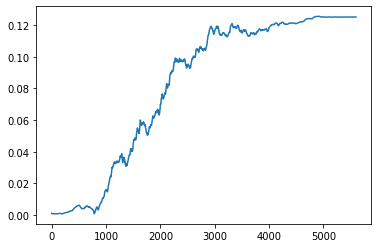

In [282]:
plt.plot(learn_b0_arl.alphas.stats[0][6])